## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pypfopt.plotting as plotting
from pypfopt.expected_returns import mean_historical_return
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import discrete_allocation
from pypfopt import expected_returns
from pypfopt import risk_models
from pypfopt import EfficientFrontier
from pypfopt import objective_functions
from pypfopt import base_optimizer
from pypfopt.discrete_allocation import DiscreteAllocation
from pypfopt.hierarchical_portfolio import HRPOpt

## Getting the Data

In [2]:
start_date = '2022-07-01'
end_date = '2023-06-30'

# Define the ticker list
tickers_list = ['AAPL', 'WMT', 'MU', 'BA','GOOG','BABA','GE','AMD','BAC','GM','T','UAA','XOM','RRC','PFE','JPM','SBUX']

# Fetch the data
import yfinance as yf
data = yf.download(tickers_list, start=start_date, end=end_date)['Adj Close']
#print(data.iloc[-1])
# Print first 5 rows of the data
#print(data.head())
#print(data.tail())

[*********************100%***********************]  17 of 17 completed


In [3]:
# Download benchmark data - We can also use Buffet's Portfolio as a Benchmark
spy_data = yf.download('SPY', start=start_date, end=end_date)['Adj Close']

[*********************100%***********************]  1 of 1 completed


## Applying Markowitz

In [4]:
# Prepare historical price data for assets
#historical_prices = pd.read_csv('historical_prices.csv', index_col=0, parse_dates=True)
historical_prices = data


# Calculate expected returns
returns = expected_returns.mean_historical_return(historical_prices)
cov_matrix = risk_models.sample_cov(historical_prices)

# Create an instance of EfficientFrontier
ef = EfficientFrontier(returns, cov_matrix,weight_bounds = (0,0.2))

# Efficient Frontier with random portfolios

Maximise the Sharpe Ratio. The result is also referred to as the tangency portfolio, as it is the portfolio for which the capital market line is tangent to the efficient frontier.

This is a convex optimization problem after making a certain variable substitution. See Cornuejols and Tutuncu (2006) for more.

Because max_sharpe() makes a variable substitution, additional objectives may not work as intended.

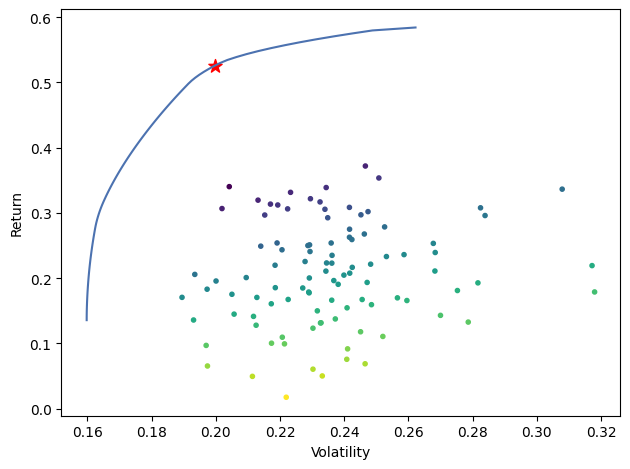

In [5]:
fig, ax = plt.subplots()
ef_optimize = ef.deepcopy()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

### Choosing Optimization Strategy (Comment out the other approach you want to use)

#adding gamma for diversification - https://pyportfolioopt.readthedocs.io/en/latest/MeanVariance.html#l2-regularisation
#ef_optimize.add_objective(objective_functions.L2_reg, gamma=1.5)


#For Max Sharpe

ef_optimize.max_sharpe()

# Markowitz with Target Volatility

#target_volatility = 0.2
#ef_optimize.efficient_risk(target_volatility)

# Find the tangency portfolio

ret_tangent, std_tangent, _ = ef_optimize.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Generate random portfolios
n_samples = 100
w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
# Normalize weights to sum up to 1 - to make sure they lie within efficient frontier
w = w / np.sum(w, axis=1, keepdims=True)  
rets = w.dot(ef.expected_returns)
stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
#ax.set_title("Efficient Frontier with random portfolios")
#ax.legend()
ax.get_legend().remove()
plt.tight_layout()
#Saves the output file as a transparent image
plt.savefig("ef_scatter.png", dpi=200, transparent=True)
plt.show()

In [6]:
# Print Weights - Max Sharpe
cleaned_weights = ef_optimize.clean_weights()
print(cleaned_weights)

OrderedDict([('AAPL', 0.16082), ('AMD', 0.0), ('BA', 0.18547), ('BABA', 0.0), ('BAC', 0.0), ('GE', 0.2), ('GM', 0.0), ('GOOG', 0.0), ('JPM', 0.10193), ('MU', 0.0), ('PFE', 0.0), ('RRC', 0.0), ('SBUX', 0.06276), ('T', 0.0), ('UAA', 0.0), ('WMT', 0.2), ('XOM', 0.08902)])


## Portfolio Performance

In [7]:
#to know the expected performance of the portfolio with optimal weights w
ef_optimize.portfolio_performance(verbose=True)

Expected annual return: 52.6%
Annual volatility: 20.0%
Sharpe Ratio: 2.53


(0.5258063672772263, 0.1997730654357011, 2.5319047198583684)

## Optimal Allocation

In [8]:
# Calculate the discrete allocation of assets based on the optimal weights
latest_prices = historical_prices.iloc[-1]  # Latest prices for the assets
da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=10000)
allocation, leftover = da.lp_portfolio()

/home/bhavya/anaconda3/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [9]:
print("Optimal Allocation:", allocation)

Optimal Allocation: {'AAPL': 8, 'BA': 9, 'GE': 19, 'JPM': 7, 'SBUX': 6, 'WMT': 13, 'XOM': 8}


## Comparison with Benchmark Chart

In [10]:
# Create an empty Series to store portfolio returns
portfolio_returns_1 = pd.Series()
portfolio_returns_1.index.name = 'Date'

# Extract unique years
unique_years = historical_prices.index.year.unique()

In [11]:
# Iterate through each year
for year in unique_years:
    
    # Filter the DataFrame for the current year
    current_year_prices = historical_prices[historical_prices.index.year == year]
    # to get the last day of the previous year prices
    previous_year_prices = historical_prices[historical_prices.index.year == year-1]
    # Concatenate the last day of the previous year with the current year's data
    # (to avoid NaN value for the first day of the year)
    concatenated_prices = pd.concat([previous_year_prices.tail(1), current_year_prices])
    
    # Perform operations on the current_year_prices
    current_year_portfolio_returns = (concatenated_prices.pct_change().dropna() * cleaned_weights).sum(axis=1)
    
    # Append current returns to the all_returns Series
    portfolio_returns_1 = pd.concat([portfolio_returns_1, current_year_portfolio_returns])
    
    # Print the result for the current year
    #print(portfolio_returns_1)

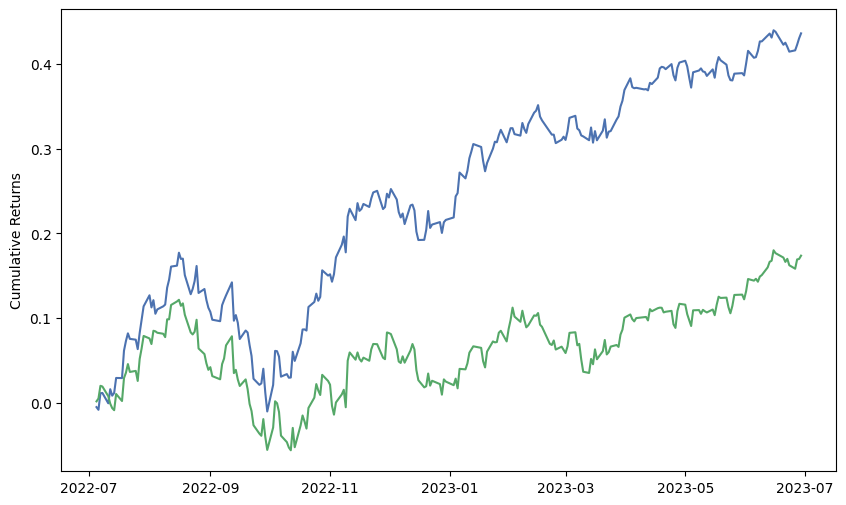

In [18]:
# Calculate portfolio and benchmark returns
portfolio_returns = portfolio_returns_1
benchmark_returns = spy_data.pct_change().dropna()

# Plot the returns
plt.figure(figsize=(10, 6), facecolor='none')
plt.plot(portfolio_returns.cumsum(), label='Portfolio Returns')
plt.plot(benchmark_returns.cumsum(), label='SPY Returns')
#plt.legend()
#plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
#plt.title('Portfolio Returns vs SPY Returns')
# Remove background grid lines
plt.grid(visible=False)
plt.savefig('portfolio_vs_spy.png', transparent=True)

### Hierarchical Risk Parity
HRP is a modern portfolio optimization method inspired by machine learning.

The idea is that by examining the hierarchical structure of the market, we can better diversify.

In [13]:
rets = expected_returns.returns_from_prices(historical_prices)

In [14]:
hrp = HRPOpt(rets)
hrp.optimize()
weights = hrp.clean_weights()
weights

OrderedDict([('AAPL', 0.04901),
             ('AMD', 0.01554),
             ('BA', 0.04944),
             ('BABA', 0.03046),
             ('BAC', 0.02907),
             ('GE', 0.05981),
             ('GM', 0.03174),
             ('GOOG', 0.03136),
             ('JPM', 0.03596),
             ('MU', 0.02587),
             ('PFE', 0.13983),
             ('RRC', 0.02054),
             ('SBUX', 0.08281),
             ('T', 0.10322),
             ('UAA', 0.01921),
             ('WMT', 0.20661),
             ('XOM', 0.06951)])

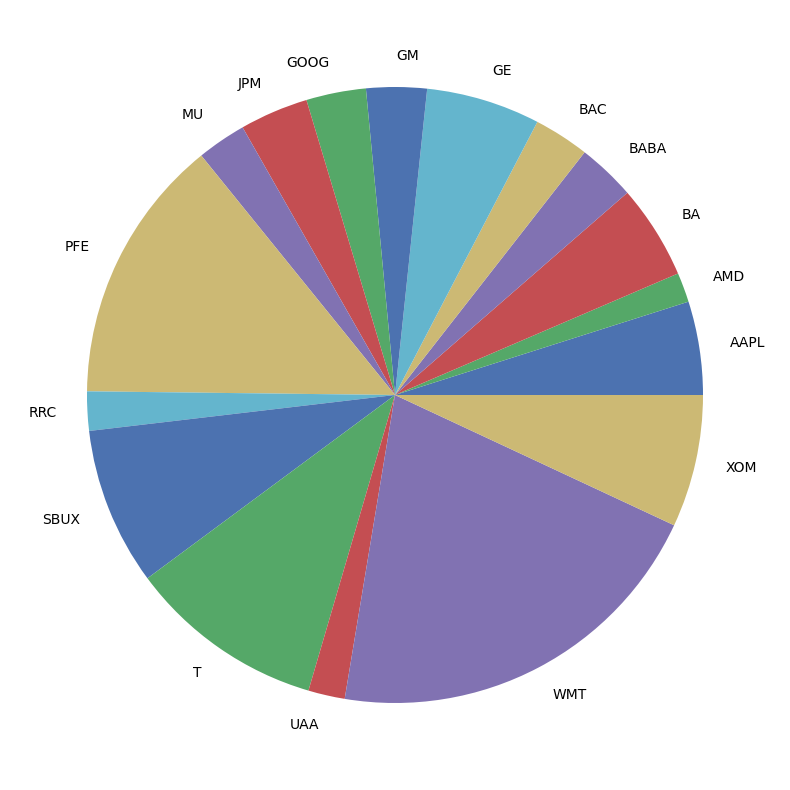

In [15]:
pd.Series(weights).plot.pie(figsize=(10, 10));

In [16]:
hrp.portfolio_performance(verbose=True);

Expected annual return: 16.5%
Annual volatility: 17.7%
Sharpe Ratio: 0.81


### Plotting

Plotting a dendrogram (tree diagram) based on the hierarchical structure of asset returns

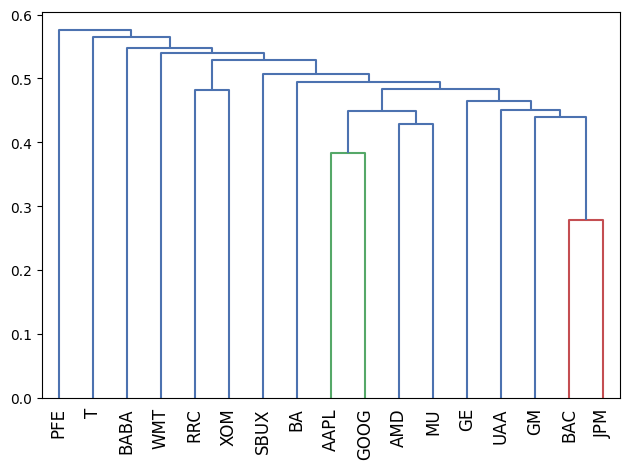

In [17]:
plotting.plot_dendrogram(hrp); 

## Markowitz with Monthly Rebalancing keeping Original Weights Only

TODO

## Markowitz with Monthly Rebalancing - With Original Weights Revising every 12 months

TODO